<br>
<b>
    <font size="10" face="verdana">AI Fall 99 CA 3</font>
</b>
<hr>

## By Kimia Khabiri

## Introduction
In our world, most of industries use different artificial intelligence methods to improve their products. One of these, is classifying texts to determine some property about them. In this project we build a mechanism to classify comments in two <i>recommended</i> and <i>not recommended</i> categories . We use machine learning algorithms to do this task.<br>

## Implementation

### Phase 1: Data Preprocessing
In this phase we are going to preprocess text data to get better results in future processing steps.

I used <a href="https://www.sobhe.ir/hazm/">Hazm</a> library to normalize data and as normalization steps I removed step words and replace remaining words with their root using <i>limmatization</i> method.

Here is brief explanation of <i>stemming</i> and <i>lemmatization</i> methods:
##### Stemming method
In this method words are replaced with their singular form. for example the result of applying stem method on word <i>کتاب‌ها</i> will be  <i>کتاب</i>

##### Lemmatization method
In this method words are replaced with their root form. for example the result of applying stem method on word <i>می‌روم</i> will be  <i>رفت#رو</i>

In this implementation we test both lemmatization and stemming methods, it impacted little effect on the result although better results observed using lemmatization method.

### Phase 2: Problem Process
Classification is done using the Bayesian formula and naive bayes.
<img src="./Images/Bayesian_formula.png"/> <br>
The following is an explanation of each of the parameters value in this implementation.

##### Evidence
Evidences are the probability of the words that make up the comment we want to classify.
##### Prior
this parameter indicates the probability of each category and calculated by dividing number of records of that specific category by number of all records.
##### Posterior
this is the output of bayes rule and indicates the probability of belonging comment to category y, if it contains words  available in evidence.
##### Likelihood
likelihood indicates how much is it possible that we see words in the evidence in predetermined category.
to calculate this probability for words, we must divide the number of times we see that word in that category by the number of all existed words in that specific category.

as it is shown in the bottom of bayes rule picture, there's another way to calcute posterior probablity. this phrase is just another form of bayes rule.

### Additive Smoothing
Consider situation that there is a word in the a record in test data that never seen before in train data records related to a specific category. so the likelihood value for this word is going to be 0 and by multiplying this value in other liklihood for other words we still going to have probability 0 as the result.
this is obviously wrong answer, because it is possible that the other words in the record do have a good likelihood value that might result as a good predection for the record but because of this new word the effect of all other possiblities is gone.

to prevent this case, there is a method called <b>Additive Smoothing</b> method.
this method added small amount of noise to all calculated probabilties to solve zero probability problem.
new probabilities are calculated using this formula:
<img src="./Images/additive_smoothing.png"/> <br>

explanation of formula parameters.
##### Theta
this is the value that used instead of raw probability to prevent problem indicated above.
##### Alpha
alpha is a additive smoothing parameter and is greater than 0. zero value for alpha correspond to no smoothing. 
##### Parameter d
in this problem, d is number of different words that are available in all categories.

as we see, theta is greater than zero. so the problem described above will not happen.

In [75]:
import pandas as pd
import math
from hazm import *

TITLE_COL = 'title'
COMMENT_COL = 'comment'
RECOMMEND_COL = 'recommend'
WORDS_COL = 'keywords'
ALPHA = 1
# stopwords = stopwords_list() + ['.', '!', '?', ',']
stopwords = []

class Classifier:
    def __init__(self, dataFileAddr, testFileAddr, additiveSmoothing = True, preprocessing = True):
        self.dataFileAddr = dataFileAddr
        self.testFileAddr = testFileAddr
        self.recommendDict = {}
        self.notRecommendDict = {}
        self.recomadvalue = {}
        self.additiveSmoothing = additiveSmoothing
        self.preprocessing = preprocessing
        self.lemmatize = True
        self.wrongClassifications = pd.DataFrame(columns=['Phrase' ,'Recommended', 'Prediction'])
     
    
    def run(self):
        self.data = self.preProcessData(self.dataFileAddr)
        self.train()
        self.testData = self.preProcessData(self.testFileAddr)
        evaluationResults = self.test()
        return evaluationResults
    
    
    def preProcessData(self, path):
        df = pd.read_csv(path)
        normalizer = Normalizer()
        lemmatizer = Lemmatizer()
        stemmer = Stemmer()
        wordsCol = []

        if(self.preprocessing):
            for index, row in df.iterrows():
                description = normalizer.normalize(row[TITLE_COL] + " " + row[COMMENT_COL])
                words = word_tokenize(description)
                if(self.lemmatize):
                    filteredWords = [lemmatizer.lemmatize(w) for w in words if w not in stopwords]
                else:
                    filteredWords = [stemmer.stem(w) for w in words if w not in stopwords]
                wordsCol.append(filteredWords)

            df.drop([TITLE_COL, COMMENT_COL], axis=1, inplace=True)
            df[WORDS_COL] = wordsCol
            return df
        else:
            for index, row in df.iterrows():
                description = row[TITLE_COL] + " " + row[COMMENT_COL]
                words = word_tokenize(description)
                wordsCol.append(words)

            df.drop([TITLE_COL, COMMENT_COL], axis=1, inplace=True)
            df[WORDS_COL] = wordsCol
            return df            
    
    
    def train(self):
        recommendDf = self.data.loc[self.data[RECOMMEND_COL] == 'recommended']
        notRecommendDf = self.data.loc[self.data[RECOMMEND_COL] == 'not_recommended'] 
        
        separatedWordsCount = 0
        recommendedWordsCount = 0
        for index, row in recommendDf.iterrows():
            for word in row[WORDS_COL]:
                recommendedWordsCount += 1
                if word not in self.recommendDict:
                    separatedWordsCount += 1
                    self.recommendDict[word] = 1
                else:
                    self.recommendDict[word] += 1

            
        notRecommendedWordsCount = 0            
        for index, row in notRecommendDf.iterrows():
            for word in row[WORDS_COL]:
                notRecommendedWordsCount += 1
                if word not in self.notRecommendDict:
                    self.notRecommendDict[word] = 1
                    if(word not in self.recommendDict):
                        separatedWordsCount += 1
                else:
                    self.notRecommendDict[word] += 1

                        
        if(self.additiveSmoothing):
            for key, value in self.recommendDict.items():
                p = (value + ALPHA) / (recommendedWordsCount + ALPHA * separatedWordsCount)
                self.recomadvalue[key] = value
                self.recommendDict[key] = p
            for key, value in self.notRecommendDict.items():
                p = (value + ALPHA) / (notRecommendedWordsCount + ALPHA * separatedWordsCount)
                self.recomadvalue[key] = value
                self.notRecommendDict[key] = p
        else:
            for key, value in self.recommendDict.items():
                p = value/recommendedWordsCount
                self.recomadvalue[key] = value
                self.recommendDict[key] = p
            for key, value in self.notRecommendDict.items():
                p = value/notRecommendedWordsCount
                self.recomadvalue[key] = value
                self.notRecommendDict[key] = p
                
        self.wordsCount = separatedWordsCount
        self.recommendedWordsCount = recommendedWordsCount
        self.notRecommendedWordsCount = notRecommendedWordsCount
    
    
    def test(self):
        recommendDf = self.testData.loc[self.testData[RECOMMEND_COL] == 'recommended']
        notRecommendDf = self.testData.loc[self.testData[RECOMMEND_COL] == 'not_recommended']
        
        correctRecommandGuess = 0
        wrongRecommandGuess = 0
        for index, row in recommendDf.iterrows():
            recommendChance = self.recommendPosteriorProbability(row[WORDS_COL])
            notRecommendChance = self.notRecommendPosteriorProbability(row[WORDS_COL])
            if(recommendChance >= notRecommendChance):
                correctRecommandGuess += 1
            else:
                data = [{'Phrase': row[WORDS_COL] ,'Recommended': 'recommended', 'Prediction': 'not recommended'}]
                self.wrongClassifications = self.wrongClassifications.append(data, ignore_index=True)
                wrongRecommandGuess += 1
                
        correctNotRecommandGuess = 0
        wrongNotRecommandGuess = 0
        for index, row in notRecommendDf.iterrows():
            recommendChance = self.recommendPosteriorProbability(row[WORDS_COL])
            notRecommendChance = self.notRecommendPosteriorProbability(row[WORDS_COL])
            if(notRecommendChance >= recommendChance):
                correctNotRecommandGuess += 1
            else:
                wrongNotRecommandGuess += 1
        
        accuracy = (correctRecommandGuess + correctNotRecommandGuess) / len(self.testData)
        precision = (correctRecommandGuess) / (correctRecommandGuess + wrongNotRecommandGuess)
        recall = (correctRecommandGuess) / len(recommendDf)
        F1 = 2 * ( (precision * recall) / (precision + recall))
        
        return accuracy, precision, recall, F1
                
            
    def recommendPosteriorProbability(self,words):
        p = 0.5
        for word in words:
            if word in self.recommendDict:
                p *= self.recommendDict[word]
            else:
                if(self.additiveSmoothing):
                    p *= (ALPHA / (self.recommendedWordsCount + ALPHA * self.wordsCount))
                else:
                    p *= 10^-6
        return p
    
    def notRecommendPosteriorProbability(self,words):
        p = 0.5
        for word in words:
            if word in self.notRecommendDict:
                p *= self.notRecommendDict[word]        
            else:       
                if(self.additiveSmoothing):
                    p *= (ALPHA / (self.notRecommendedWordsCount + ALPHA * self.wordsCount))  
                else:
                    p *= 10^-6
        return p

### Phase 3: Evaluation

we use four characteristic to evaluate our model.
<img src="./Images/accuracy.png"/> <br>
<img src="./Images/precision.png"/> <br>
<img src="./Images/recall.png"/> <br>
<img src="./Images/f1.png"/> <br>

precision and recall values are not helpfull independently and should come together to make sense.to explain why presicion is not good independently, suppose we classify all of are records in not recommended category except on record, and for that single record, recommended category is a true classification. in this case precision value is 100% but yet we had not design a good model. also as an example to describe why recall value is not good enough independently,suppose our model classify all data records in recommended category. in this case recall value calculated as 100% but we know that are model is not acting well.

To enter the values calculated by precision and recall in our calculations, we use parameter F1. F1 calculates harmonic mean from precision and recall. This formula usually used to take average between rates. 

here is general formula of harmonic mean.
<img src="./Images/harmonic_mean.png"/> <br>


In [77]:
outDf = pd.DataFrame(columns=['', 'A', 'B', 'C', 'D'])
outDf[''] = ['Accuracy', 'Precision', 'Recall', 'F1']
cl = Classifier('CA3_dataset/comment_train.csv','CA3_dataset/comment_test.csv', True, True)
outDf['A'] = cl.run()
wrongClassifications = cl.wrongClassifications.tail(5)

In [78]:
cl = Classifier('CA3_dataset/comment_train.csv','CA3_dataset/comment_test.csv', True, False)
outDf['B'] = cl.run()

In [79]:
cl = Classifier('CA3_dataset/comment_train.csv','CA3_dataset/comment_test.csv', False, True)
outDf['C'] = cl.run()

In [80]:
cl = Classifier('CA3_dataset/comment_train.csv','CA3_dataset/comment_test.csv', False, False)
outDf['D'] = cl.run()

In [81]:
display(outDf)

A         B         C         D
0   Accuracy  0.937500  0.940000  0.703750  0.666250
1  Precision  0.928922  0.929268  0.699267  0.664198
2     Recall  0.947500  0.952500  0.715000  0.672500
3         F1  0.938119  0.940741  0.707046  0.668323

<function matplotlib.pyplot.show(close=None, block=None)>

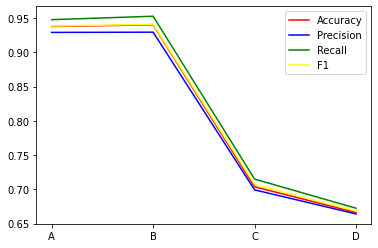

In [82]:
import matplotlib.pyplot as plt

plotDf = pd.DataFrame()
plotDf['Model'] = ['A', 'B', 'C', 'D']
plotDf['Accuracy'] = [outDf['A'][0], outDf['B'][0], outDf['C'][0], outDf['D'][0]]
plotDf['Precision'] = [outDf['A'][1], outDf['B'][1], outDf['C'][1], outDf['D'][1]]
plotDf['Recall'] = [outDf['A'][2], outDf['B'][2], outDf['C'][2], outDf['D'][2]]
plotDf['F1'] = [outDf['A'][3], outDf['B'][3], outDf['C'][3], outDf['D'][3]]
plotDf


plt.plot(plotDf['Model'], plotDf['Accuracy'], label= 'Accuracy', color='red')
plt.plot(plotDf['Model'], plotDf['Precision'], label= 'Precision', color='blue')
plt.plot(plotDf['Model'], plotDf['Recall'], label= 'Recall', color='green')
plt.plot(plotDf['Model'], plotDf['F1'], label= 'F1', color='yellow')
plt.legend()
plt.show

As we excpected, accuracy decreases from A to D.
At each stage, different parameters have values close to each other, which makes this model homogeneos.

In [83]:
display(wrongClassifications)

Phrase  Recommended  \
16  [دیر, شارژ, میکند, اصلا, کیفیت, داشت#دار, ., ۲...  recommended   
17  [کیفیت, پایین, طراح, و, مونتاژ, کیفیت, کیت, و,...  recommended   
18  [ماساژور, مینی, بدک, نیست, خوبه, با, باتری, ام...  recommended   
19  [خریدار, محصول, بسته‌ای, که, سفارش, داد#ده, و,...  recommended   
20  [پیشنهاد, نمیدم, من, دوسه, ماه, #هست, این, کفش...  recommended   

         Prediction  
16  not recommended  
17  not recommended  
18  not recommended  
19  not recommended  
20  not recommended

There are several reasons for the mistakes that are made in the classification of records. It may be possible to reduce the error rate with better pre processing.
Also, you can not always be sure that if a comment uses more positive words, it will necessarily end up offering that product. Because we make our estimates of the load of each word based on a limited amount of data and at last we are just predecting and we do not except 100% of accuracy.